In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install wandb -qU
%pip install --no-deps scikeras
%pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.2/213.2 kB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 23.0 MB/s eta 0:00:00


In [ ]:
#imports
import wandb
from wandb.keras import WandbCallback
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_auc_score
import tensorflow_addons as tfa
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.optimizers import SGD
from keras.layers import Dropout

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Data processing **

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [ ]:
#Upload Real Datasets
df_real1 = pd.read_csv('/content/drive/MyDrive/Zach/RealData/Blue Order 1 (Ready_4ML).csv')
df_real2 = pd.read_csv('/content/drive/MyDrive/Zach/RealData/Red Order 1 (REady_4ML).csv')
df_real3 = pd.read_csv('/content/drive/MyDrive/Zach/RealData/White Order 1 (Ready_4ML).csv')

df_real1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df_real2.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df_real3.rename(columns={'Run Time ': 'Run Time'}, inplace=True)


df2 = df_real1.append(df_real2.append(df_real3))

<ipython-input-5-219118522143>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df_real1.append(df_real2.append(df_real3))


In [ ]:
#Upload Simulated Dataset
df1 = pd.read_csv('/content/drive/MyDrive/Zach/mergedata/RWB_SimDataCombined.csv')

# Rename the 'B' column to 'C' in-place
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)

df1['type'] = 0 #SimData
df2['type'] = 1 #RealData
df_combined = df1.append(df2)
df_combined

<ipython-input-6-909f6320fecb>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df1.append(df2)


,Run Time,msg,node,topics,type
0,0.000000,Published Order,/Order,"/new_order, /rosout",0
1,0.235499,VGR got something,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",0
2,0.288815,VGR is Moving to HBW,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",0
3,0.300417,HBW Recieved an Order,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",0
4,18.445745,HBW Picked Up Material,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",0
...,...,...,...,...,...
33,18.463000,HBW Picked Up Material,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",1
34,0.265810,VGR is Moving to HBW,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",1
35,0.254050,VGR got something,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",1
36,0.248460,HBW Received an Order,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",1


In [ ]:
df_combined['topics'] = df_combined['topics'].apply(lambda x: x.replace(" ", ""))
df_combined

,Run Time,msg,node,topics,type
0,0.000000,Published Order,/Order,"/new_order,/rosout",0
1,0.235499,VGR got something,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",0
2,0.288815,VGR is Moving to HBW,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",0
3,0.300417,HBW Recieved an Order,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",0
4,18.445745,HBW Picked Up Material,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",0
...,...,...,...,...,...
33,18.463000,HBW Picked Up Material,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",1
34,0.265810,VGR is Moving to HBW,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",1
35,0.254050,VGR got something,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",1
36,0.248460,HBW Received an Order,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",1


In [ ]:
# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
df_combined['topics']= label_encoder.fit_transform(df_combined['topics'])
df_combined['msg']= label_encoder.fit_transform(df_combined['msg'])
df_combined['node']= label_encoder.fit_transform(df_combined['node'])
df_combined

,Run Time,msg,node,topics,type
0,0.000000,25,0,4,0
1,0.235499,37,7,2,0
2,0.288815,39,7,2,0
3,0.300417,21,1,0,0
4,18.445745,14,1,0,0
...,...,...,...,...,...
33,18.463000,14,1,0,1
34,0.265810,39,7,2,1
35,0.254050,37,7,2,1
36,0.248460,20,1,0,1


In [ ]:
#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df_combined.drop(predict, axis=1)
y = df_combined[predict]
print(X.head())
print(y.head())

    Run Time  msg  node  topics
0   0.000000   25     0       4
1   0.235499   37     7       2
2   0.288815   39     7       2
3   0.300417   21     1       0
4  18.445745   14     1       0
0    0
1    0
2    0
3    0
4    0
Name: type, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test =  sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=True)

print(f'Train y: {y_train.shape}')
print(f'Train X: {X_train.shape}')
print(f'Test y: {y_test.shape}')
print(f'Test X: {X_test.shape}')

Train y: (159,)
Train X: (159, 4)
Test y: (69,)
Test X: (69, 4)


In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [ ]:
# Example sweep configuration
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize',
        'name': 'f1_score'
		},
    'parameters': {
        'batch_size': {'values': [10,15,25,32,50,64,75,100]},
        'epochs': {'values': [50,75,100,125,150,200,250,300]},
        'fc_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'sc_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'Td_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'Frth_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'lr': {'max': 0.1, 'min': 0.0001},
        'optimizer':{'values': ['adam','SGD','RMSprop','nadam','Adadelta','Adagrad','Adamax','Ftrl','AdamW']},
        'dropout': {'values': [0, 0.3, 0.5]},
     },

}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="NN_Turing", entity="dt_zach")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: odywlx9s
Sweep URL: https://wandb.ai/dt_zach/NN_Turing/sweeps/odywlx9s


In [ ]:
def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)
    if optimizer.lower() == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    if optimizer.lower() == "nadam":
        return tf.keras.optimizers.Nadam(learning_rate=lr)
    if optimizer.lower() == "adadelta":
        return tf.keras.optimizers.Adadelta(learning_rate=lr)
    if optimizer.lower() == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=lr)
    if optimizer.lower() == "adamax":
        return tf.keras.optimizers.Adamax(learning_rate=lr)
    if optimizer.lower() == "ftrl":
        return tf.keras.optimizers.Ftrl(learning_rate=lr)
    if optimizer.lower() == "adamw":
        return tf.keras.optimizers.AdamW(learning_rate=lr)

In [ ]:
def Nerual_Net(fc_layer_size=11,sc_layer_size=7,Td_layer_size=7,Frth_layer_size=7,dropout=0):
  # Set the GPU as the backend for Keras
  config = tf.compat.v1.ConfigProto()
  config.gpu_options.allow_growth = True
  sess = tf.compat.v1.Session(config=config)
  tf.compat.v1.keras.backend.set_session(sess)
  # initiate Network
  network = Sequential()

  # input layer that is fully connected with ReLU activation
  network.add(Dense(4, input_dim=4, activation="relu",use_bias=True,bias_initializer="glorot_normal", kernel_initializer="he_normal"))
  network.add(Dropout(dropout))

  #hiddent layers
  network.add(Dense(fc_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))
  # 2nd hiddent layers
  network.add(Dense(sc_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))
  # 3rd hiddent layers
  network.add(Dense(Td_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))
  # 4th hidden layers
  network.add(Dense(Frth_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))


  #Output layer that is fully connected with sigmoid activation
  network.add(Dense(1, activation="sigmoid",kernel_initializer="glorot_normal"))


  #return completed network
  return network

In [ ]:
def train(model, batch_size=64, epochs=10, lr=1e-3, optimizer='adam', log_freq=10):

    # Compile model like you usually do.
    tf.keras.backend.clear_session()
    model.compile(optimizer=get_optimizer(lr, optimizer) ,
               loss="binary_crossentropy",
               metrics=["binary_accuracy",
               tfa.metrics.F1Score(num_classes=2,
                                  average='binary',
                                  threshold=0.5),
               tf.keras.metrics.AUC(from_logits=True)
                        ])

    model.fit(X_train,
              y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              callbacks=[WandbCallback()])

In [ ]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "TestLabfab"
        wandb.config.dataset_name = "Labfab"

        # initialize model
        model = Nerual_Net(wandb.config.fc_layer_size,wandb.config.sc_layer_size,wandb.config.Td_layer_size,wandb.config.Frth_layer_size,wandb.config.dropout)

        train(model,
              wandb.config.batch_size,
              wandb.config.epochs,
              wandb.config.lr,
              wandb.config.optimizer)

In [ ]:
import pprint
pprint.pprint(sweep_configuration)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'f1_score'},
 'name': 'sweep',
 'parameters': {'Frth_layer_size': {'values': [7,
                                               9,
                                               11,
                                               13,
                                               15,
                                               20,
                                               25,
                                               30,
                                               50]},
                'Td_layer_size': {'values': [7, 9, 11, 13, 15, 20, 25, 30, 50]},
                'batch_size': {'values': [10, 15, 25, 32, 50, 64, 75, 100]},
                'dropout': {'values': [0, 0.3, 0.5]},
                'epochs': {'values': [50, 75, 100, 125, 150, 200, 250, 300]},
                'fc_layer_size': {'values': [7, 9, 11, 13, 15, 20, 25, 30, 50]},
                'lr': {'max': 0.1, 'min': 0.0001},
                'optimizer':

In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=150)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
run = wandb.init(project="NN_Turing", entity="dt_zach")

wandb: Currently logged in as: zdewardener (dt_zach). Use `wandb login --relogin` to force relogin


Testing the best model from Wandb Sweep

In [ ]:
#Build the model
def Neural_Net():

  # initiate Network
  network = Sequential()

  # input layer that is fully connected with ReLU activation
  network.add(Dense(4, input_dim=4, activation="relu",use_bias=True,bias_initializer="glorot_normal", kernel_initializer="he_normal"))
  network.add(Dropout(0))
  #hidden layers
  network.add(Dense(11, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0))
  network.add(Dense(13, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0))
  network.add(Dense(11, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0))
  network.add(Dense(30, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))

  #Output layer that is fully connected with sigmoid activation
  network.add(Dense(1, activation="sigmoid",kernel_initializer="glorot_normal"))


  # Compile network model.
  network.compile(optimizer=get_optimizer(0.02723, 'Adamax'),
               loss="binary_crossentropy",
               metrics=["binary_accuracy",
               tfa.metrics.F1Score(num_classes=2,
                                  average='binary',
                                  threshold=0.5),
               tf.keras.metrics.AUC(from_logits=False)
                        ])


  #return completed network
  return network

In [ ]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(
                                 model=Neural_Net,
                                 epochs=250,
                                 batch_size=25,
                                 verbose=0,
                                 callbacks=[WandbCallback()]
                                 )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


K_fold to ???????

In [ ]:
#Setup stratified Kfold for cross validation
seed = 123457
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)

In [ ]:
#shows how good the model is
predictions = cross_val_predict(neural_network, X_train, y_train, cv=kfold)

[[36 46]
 [35 42]] 



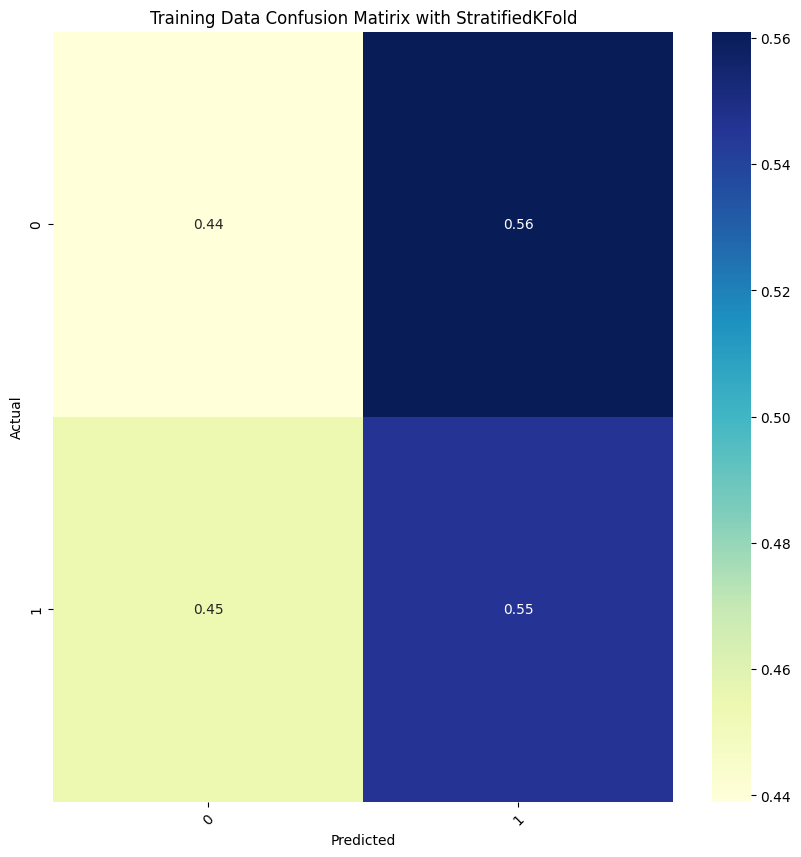


F1 Score: 0.48983957219251334
Precision: 0.4926255647090087
Recall: 0.4922394678492239
Accuracy: 0.49056603773584906


In [ ]:
conf_matrix = confusion_matrix(y_train, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Data Confusion Matirix with StratifiedKFold')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, predictions, average='binary')))
print('Precision: {}'.format(
    precision_score(y_train, predictions, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, predictions, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, predictions, average='binary')))

Test data confrimation

In [ ]:
model = Neural_Net()
#Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=100, callbacks=[WandbCallback()])
test_pred = model.predict(X_test)


Epoch 1/300
1/2 [==============>...............] - ETA: 2s - loss: 20.5983 - binary_accuracy: 0.4800 - f1_score: 0.0000e+00 - auc_20: 0.4864

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 5s 3s/step - loss: 13.2395 - binary_accuracy: 0.4906 - f1_score: 0.0690 - auc_20: 0.4301 - val_loss: 10.3246 - val_binary_accuracy: 0.5362 - val_f1_score: 0.6981 - val_auc_20: 0.4291
Epoch 2/300
1/2 [==============>...............] - ETA: 0s - loss: 11.0949 - binary_accuracy: 0.4300 - f1_score: 0.6014 - auc_20: 0.5335

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 9.0221 - binary_accuracy: 0.4843 - f1_score: 0.6525 - auc_20: 0.5196 - val_loss: 3.1373 - val_binary_accuracy: 0.5362 - val_f1_score: 0.6981 - val_auc_20: 0.4223
Epoch 3/300
2/2 [==============================] - 0s 82ms/step - loss: 3.3301 - binary_accuracy: 0.4654 - f1_score: 0.5304 - auc_20: 0.4517 - val_loss: 3.9958 - val_binary_accuracy: 0.4928 - val_f1_score: 0.1026 - val_auc_20: 0.5781
Epoch 4/300
1/2 [==============>...............] - ETA: 0s - loss: 3.6259 - binary_accuracy: 0.5600 - f1_score: 0.0833 - auc_20: 0.5018

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 3.9317 - binary_accuracy: 0.5031 - f1_score: 0.0920 - auc_20: 0.4720 - val_loss: 2.2734 - val_binary_accuracy: 0.4783 - val_f1_score: 0.0526 - val_auc_20: 0.5904
Epoch 5/300
1/2 [==============>...............] - ETA: 0s - loss: 2.1113 - binary_accuracy: 0.6100 - f1_score: 0.0488 - auc_20: 0.4372

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 1.6381 - binary_accuracy: 0.5031 - f1_score: 0.0482 - auc_20: 0.5270 - val_loss: 1.8992 - val_binary_accuracy: 0.4928 - val_f1_score: 0.6316 - val_auc_20: 0.4096
Epoch 6/300
2/2 [==============================] - 0s 68ms/step - loss: 2.0152 - binary_accuracy: 0.5157 - f1_score: 0.6578 - auc_20: 0.5218 - val_loss: 2.8106 - val_binary_accuracy: 0.5362 - val_f1_score: 0.6981 - val_auc_20: 0.4164
Epoch 7/300
1/2 [==============>...............] - ETA: 0s - loss: 2.4854 - binary_accuracy: 0.4800 - f1_score: 0.6486 - auc_20: 0.5669

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 2.4686 - binary_accuracy: 0.4717 - f1_score: 0.6348 - auc_20: 0.5279 - val_loss: 1.6402 - val_binary_accuracy: 0.4783 - val_f1_score: 0.6170 - val_auc_20: 0.4088
Epoch 8/300
1/2 [==============>...............] - ETA: 0s - loss: 1.6358 - binary_accuracy: 0.4900 - f1_score: 0.6107 - auc_20: 0.5175

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 1.3035 - binary_accuracy: 0.5157 - f1_score: 0.6316 - auc_20: 0.4884 - val_loss: 0.8882 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.6056
Epoch 9/300
2/2 [==============================] - 0s 69ms/step - loss: 0.9821 - binary_accuracy: 0.5094 - f1_score: 0.0000e+00 - auc_20: 0.4964 - val_loss: 1.4436 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.5988
Epoch 10/300
2/2 [==============================] - 0s 64ms/step - loss: 1.4586 - binary_accuracy: 0.5157 - f1_score: 0.0000e+00 - auc_20: 0.4899 - val_loss: 1.2061 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.6056
Epoch 11/300
1/2 [==============>...............] - ETA: 0s - loss: 1.2323 - binary_accuracy: 0.5300 - f1_score: 0.0000e+00 - auc_20: 0.4755

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 1.1455 - binary_accuracy: 0.5157 - f1_score: 0.0000e+00 - auc_20: 0.5021 - val_loss: 0.7740 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.5988
Epoch 12/300
2/2 [==============================] - 0s 66ms/step - loss: 0.7563 - binary_accuracy: 0.5031 - f1_score: 0.3130 - auc_20: 0.4725 - val_loss: 0.8041 - val_binary_accuracy: 0.4493 - val_f1_score: 0.5870 - val_auc_20: 0.3999
Epoch 13/300
2/2 [==============================] - 0s 65ms/step - loss: 0.8194 - binary_accuracy: 0.5283 - f1_score: 0.6269 - auc_20: 0.5179 - val_loss: 0.9644 - val_binary_accuracy: 0.4493 - val_f1_score: 0.5870 - val_auc_20: 0.3978
Epoch 14/300
2/2 [==============================] - 0s 67ms/step - loss: 0.9033 - binary_accuracy: 0.5283 - f1_score: 0.6231 - auc_20: 0.5107 - val_loss: 0.8401 - val_binary_accuracy: 0.4493 - val_f1_score: 0.5870 - val_auc_20: 0.3991
Epoch 15/300
1/2 [==============>...............] - ETA: 0s - loss:

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.7606 - binary_accuracy: 0.5346 - f1_score: 0.6263 - auc_20: 0.5367 - val_loss: 0.7067 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.4527
Epoch 16/300
2/2 [==============================] - 0s 61ms/step - loss: 0.7106 - binary_accuracy: 0.5283 - f1_score: 0.0964 - auc_20: 0.4888 - val_loss: 0.7723 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.5777
Epoch 17/300
2/2 [==============================] - 0s 61ms/step - loss: 0.7747 - binary_accuracy: 0.5283 - f1_score: 0.0741 - auc_20: 0.4977 - val_loss: 0.7861 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.5752
Epoch 18/300
2/2 [==============================] - 0s 60ms/step - loss: 0.7713 - binary_accuracy: 0.5220 - f1_score: 0.0732 - auc_20: 0.5097 - val_loss: 0.7295 - val_binary_accuracy: 0.4638 - val_f1_score: 0.0000e+00 - val_auc_20: 0.5676
Epoch 19/300
2/2 [==============================] - 0s 68ms

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.6885 - binary_accuracy: 0.5283 - f1_score: 0.6231 - auc_20: 0.5621 - val_loss: 0.7065 - val_binary_accuracy: 0.4928 - val_f1_score: 0.5070 - val_auc_20: 0.4624
Epoch 50/300
1/2 [==============>...............] - ETA: 0s - loss: 0.6945 - binary_accuracy: 0.5100 - f1_score: 0.4842 - auc_20: 0.5108

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.6883 - binary_accuracy: 0.5094 - f1_score: 0.4348 - auc_20: 0.5404 - val_loss: 0.7065 - val_binary_accuracy: 0.4783 - val_f1_score: 0.2800 - val_auc_20: 0.4502
Epoch 51/300
2/2 [==============================] - 0s 70ms/step - loss: 0.6882 - binary_accuracy: 0.5283 - f1_score: 0.2857 - auc_20: 0.5620 - val_loss: 0.7091 - val_binary_accuracy: 0.4783 - val_f1_score: 0.2800 - val_auc_20: 0.4603
Epoch 52/300
2/2 [==============================] - 0s 61ms/step - loss: 0.6891 - binary_accuracy: 0.5283 - f1_score: 0.2574 - auc_20: 0.5592 - val_loss: 0.7115 - val_binary_accuracy: 0.4783 - val_f1_score: 0.2800 - val_auc_20: 0.4586
Epoch 53/300
2/2 [==============================] - 0s 64ms/step - loss: 0.6891 - binary_accuracy: 0.5283 - f1_score: 0.2574 - auc_20: 0.5537 - val_loss: 0.7127 - val_binary_accuracy: 0.4783 - val_f1_score: 0.2800 - val_auc_20: 0.4573
Epoch 54/300
2/2 [==============================] - 0s 69ms/step - loss: 0.

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.6871 - binary_accuracy: 0.5409 - f1_score: 0.4823 - auc_20: 0.5549 - val_loss: 0.7056 - val_binary_accuracy: 0.4783 - val_f1_score: 0.3333 - val_auc_20: 0.4633
Epoch 60/300
1/2 [==============>...............] - ETA: 0s - loss: 0.6815 - binary_accuracy: 0.5400 - f1_score: 0.4103 - auc_20: 0.5841

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.6874 - binary_accuracy: 0.5157 - f1_score: 0.3636 - auc_20: 0.5538 - val_loss: 0.7047 - val_binary_accuracy: 0.4783 - val_f1_score: 0.3077 - val_auc_20: 0.4586
Epoch 61/300
1/2 [==============>...............] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.4900 - f1_score: 0.3544 - auc_20: 0.5298

wandb: Adding directory to artifact (/content/wandb/run-20230711_154451-isnifpq2/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.6880 - binary_accuracy: 0.5220 - f1_score: 0.3559 - auc_20: 0.5548 - val_loss: 0.7037 - val_binary_accuracy: 0.4928 - val_f1_score: 0.3396 - val_auc_20: 0.4620
Epoch 62/300
2/2 [==============================] - 0s 52ms/step - loss: 0.6873 - binary_accuracy: 0.5220 - f1_score: 0.3770 - auc_20: 0.5599 - val_loss: 0.7061 - val_binary_accuracy: 0.4928 - val_f1_score: 0.4262 - val_auc_20: 0.4557
Epoch 63/300
2/2 [==============================] - 0s 54ms/step - loss: 0.6885 - binary_accuracy: 0.5220 - f1_score: 0.4571 - auc_20: 0.5305 - val_loss: 0.7106 - val_binary_accuracy: 0.4638 - val_f1_score: 0.5195 - val_auc_20: 0.4565
Epoch 64/300
2/2 [==============================] - 0s 53ms/step - loss: 0.6870 - binary_accuracy: 0.5346 - f1_score: 0.5843 - auc_20: 0.5579 - val_loss: 0.7114 - val_binary_accuracy: 0.4928 - val_f1_score: 0.4928 - val_auc_20: 0.4561
Epoch 65/300
2/2 [==============================] - 0s 54ms/step - loss: 0.

5/5 [==============================] - 0s 3ms/step
[[70 12]
 [64 13]] 



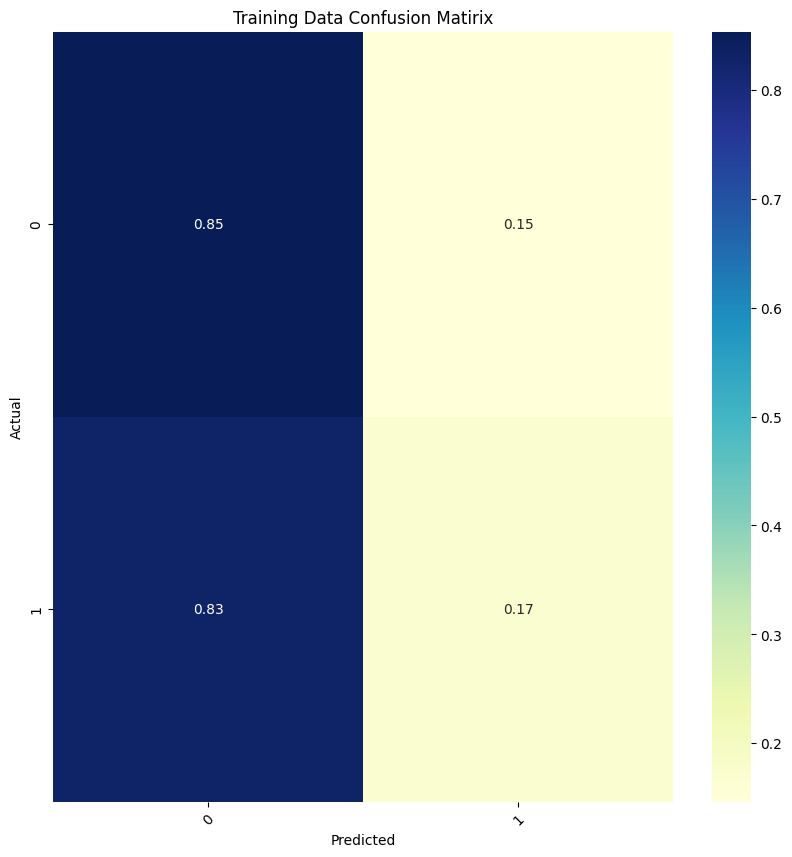


F1 Score: 0.4515250544662309
Precision: 0.5212315779592602
Recall: 0.5112448527082674
Accuracy: 0.5220125786163522


In [ ]:
predictions = (model.predict(X_train) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_train, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Data Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, predictions, average='binary')))
print('Precision: {}'.format(
    precision_score(y_train, predictions, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, predictions, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, predictions, average='binary')))

In [ ]:
predictions_test = (model.predict(X_test) > 0.5).astype("int32")

3/3 [==============================] - 0s 3ms/step


[[26  6]
 [30  7]] 



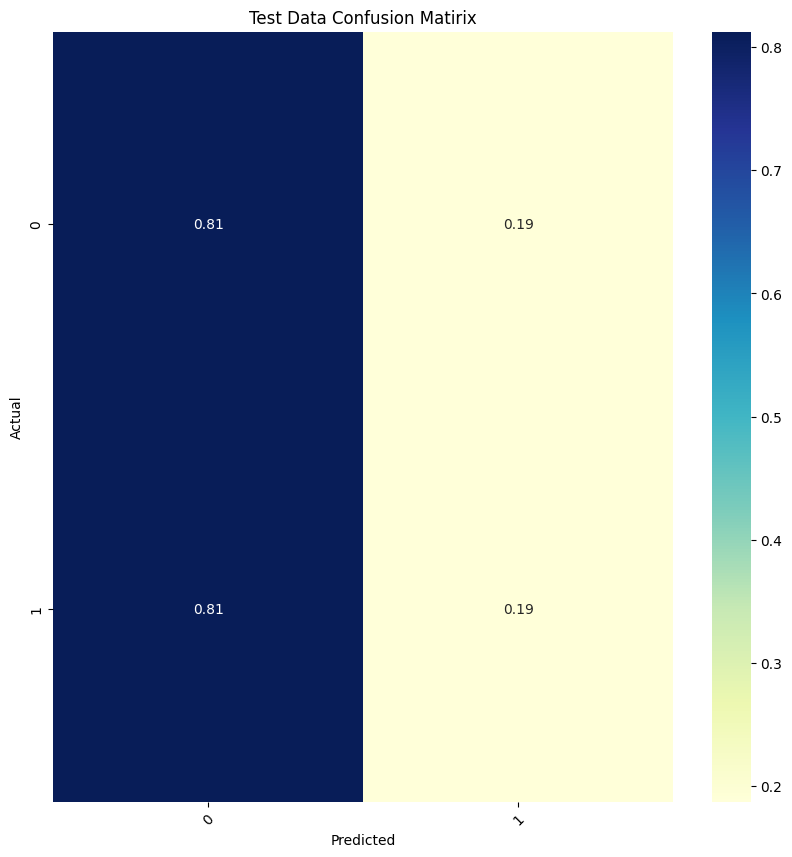


F1 Score: 0.4354545454545454
Precision: 0.5040611562350693
Recall: 0.5008445945945946
Accuracy: 0.4782608695652174


In [ ]:
conf_matrix = confusion_matrix(y_test, predictions_test)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test Data Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test, predictions_test, average='binary')))
print('Precision: {}'.format(
    precision_score(y_test, predictions_test, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_test, predictions_test, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_test, predictions_test, average='binary')))

In [ ]:
model.layers[0].get_weights()[1]

array([-0.01346976, -0.11869065, -0.03341564, -0.0836319 ], dtype=float32)

In [ ]:
#shows how good the model is
predictions = cross_val_predict(neural_network, X_test, y_test, cv=kfold)

[[16 16]
 [15 22]] 



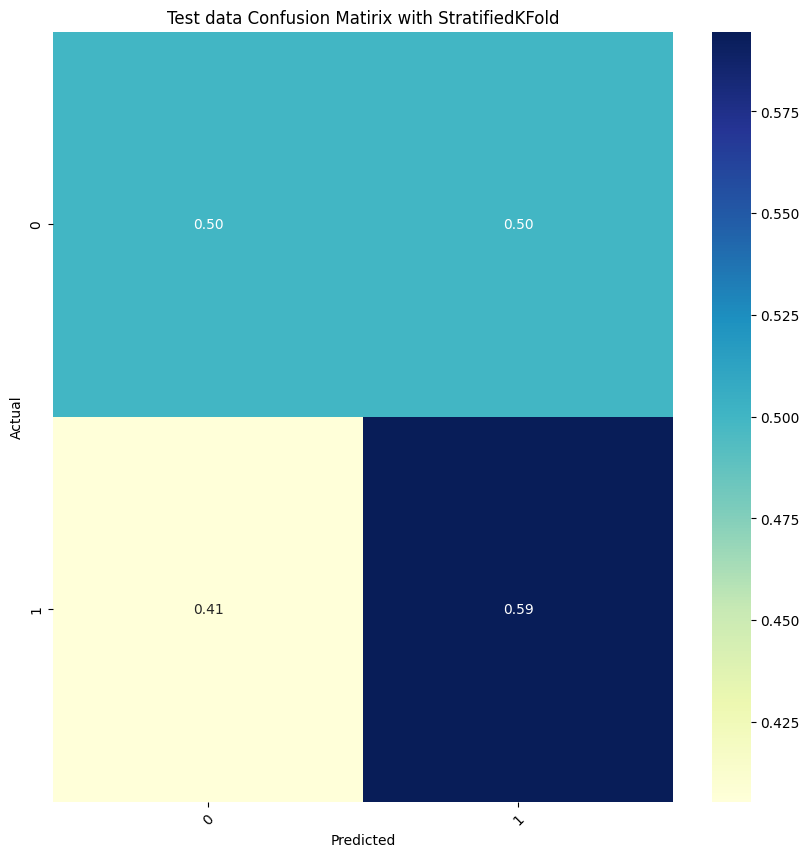


F1 Score: 0.5473015873015873
Precision: 0.5498142270121306
Recall: 0.5472972972972974
Accuracy: 0.5507246376811594


In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test data Confusion Matirix with StratifiedKFold')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test, predictions, average='binary')))
print('Precision: {}'.format(
    precision_score(y_test, predictions, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_test, predictions, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_test, predictions, average='binary')))

---------------------------------------------------------------------
Further Testing with new datasets of real and sim data

In [ ]:
%cd drive/MyDrive/Zach/RealData
%ls

/content/drive/MyDrive/Zach/RealData
'Blue Order 1 (Ready_4ML).csv'  'Red Order 3 (Ready_4ML).csv'
'Blue Order 2 (Ready4_ML).csv'  'White Order 1 (Ready_4ML).csv'
'Blue Order 3 (ready_4ML).csv'  'White Order 2 (Ready_4ML).csv'
'Red Order 1 (REady_4ML).csv'   'White Order 3 (Ready_4ML).csv'
'Red Order 2 (Ready_4ML).csv'


In [ ]:
df_real1 = pd.read_csv('/content/drive/MyDrive/Zach/RealData/Blue Order 2 (Ready4_ML).csv')
df1 = pd.read_csv('/content/drive/MyDrive/Zach/mergedata/OldData/blueSIM_test1.csv')

df_real1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
# Rename the 'B' column to 'C' in-place
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)

df2 = df_real1


df1['type'] = 0 #SimData
df2['type'] = 1 #RealData
df_combined = df1.append(df2)
df_combined

<ipython-input-31-69846b5fa4e3>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df1.append(df2)


,Run Time,msg,node,topics,type
0,0.00000,Published Order,/Order,"/new_order, /rosout",0
1,0.07000,VGR got something,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",0
2,0.07000,VGR is Moving to HBW,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",0
3,0.27000,HBW Recieved an Order,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",0
4,1.27000,HBW Picked Up Material,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",0
...,...,...,...,...,...
33,11.08581,HBW Picked Up Material,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",1
34,0.27037,HBW Received an Order,/hbw_node,"/diagnostics, /hbw_pub, /new_order, /rosout, /...",1
35,0.15989,VGR is Moving to HBW,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",1
36,0.15170,VGR got something,/vgr_node,"/diagnostics, /new_order, /provide_empty_loc, ...",1


In [ ]:
df_combined['topics'] = df_combined['topics'].apply(lambda x: x.replace(" ", ""))
df_combined

,Run Time,msg,node,topics,type
0,0.00000,Published Order,/Order,"/new_order,/rosout",0
1,0.07000,VGR got something,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",0
2,0.07000,VGR is Moving to HBW,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",0
3,0.27000,HBW Recieved an Order,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",0
4,1.27000,HBW Picked Up Material,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",0
...,...,...,...,...,...
33,11.08581,HBW Picked Up Material,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",1
34,0.27037,HBW Received an Order,/hbw_node,"/diagnostics,/hbw_pub,/new_order,/rosout,/vgr_...",1
35,0.15989,VGR is Moving to HBW,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",1
36,0.15170,VGR got something,/vgr_node,"/diagnostics,/new_order,/provide_empty_loc,/pr...",1


In [ ]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
df_combined['topics']= label_encoder.fit_transform(df_combined['topics'])
df_combined['msg']= label_encoder.fit_transform(df_combined['msg'])
df_combined['node']= label_encoder.fit_transform(df_combined['node'])
df_combined

,Run Time,msg,node,topics,type
0,0.00000,21,0,4,0
1,0.07000,30,7,2,0
2,0.07000,32,7,2,0
3,0.27000,17,1,0,0
4,1.27000,10,1,0,0
...,...,...,...,...,...
33,11.08581,10,1,0,1
34,0.27037,16,1,0,1
35,0.15989,32,7,2,1
36,0.15170,30,7,2,1


In [ ]:
#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df_combined.drop(predict, axis=1)
y = df_combined[predict]
print(X.head())
print(y.head())

   Run Time  msg  node  topics
0      0.00   21     0       4
1      0.07   30     7       2
2      0.07   32     7       2
3      0.27   17     1       0
4      1.27   10     1       0
0    0
1    0
2    0
3    0
4    0
Name: type, dtype: int64


In [ ]:
predictions_combined = (model.predict(X) > 0.5).astype("int32")

3/3 [==============================] - 0s 3ms/step


[[33  5]
 [30  8]] 



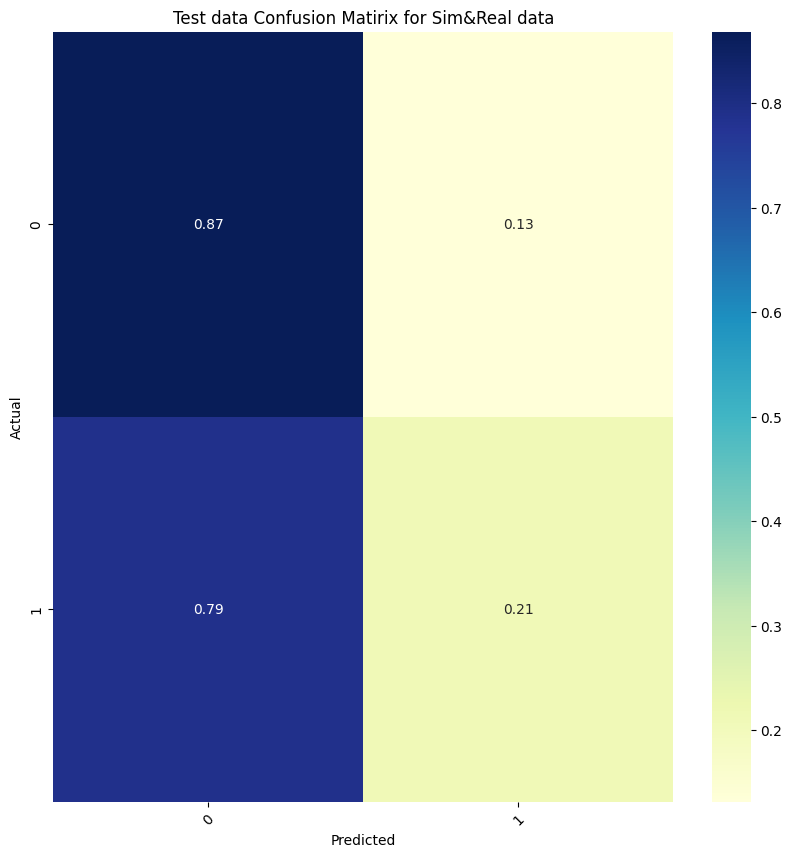


F1 Score: 0.48359541836536596
Precision: 0.5695970695970697
Recall: 0.5394736842105263
Accuracy: 0.5394736842105263


In [ ]:
conf_matrix = confusion_matrix(y, predictions_combined)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test data Confusion Matirix for Sim&Real data')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y, predictions_combined, average='binary')))
print('Precision: {}'.format(
    precision_score(y, predictions_combined, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y, predictions_combined, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y, predictions_combined, average='binary')))

-------------------------------------
Testing with only fake data

   Run Time  msg  node  topics
0      0.00   19     0       4
1      0.07   27     6       2
2      0.07   29     6       2
3      0.27   15     1       0
4      1.27    9     1       0
0    0
1    0
2    0
3    0
4    0
Name: type, dtype: int64
2/2 [==============================] - 0s 4ms/step
[[34  4]
 [ 0  0]] 



<ipython-input-37-2d6367fb10ef>:29: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


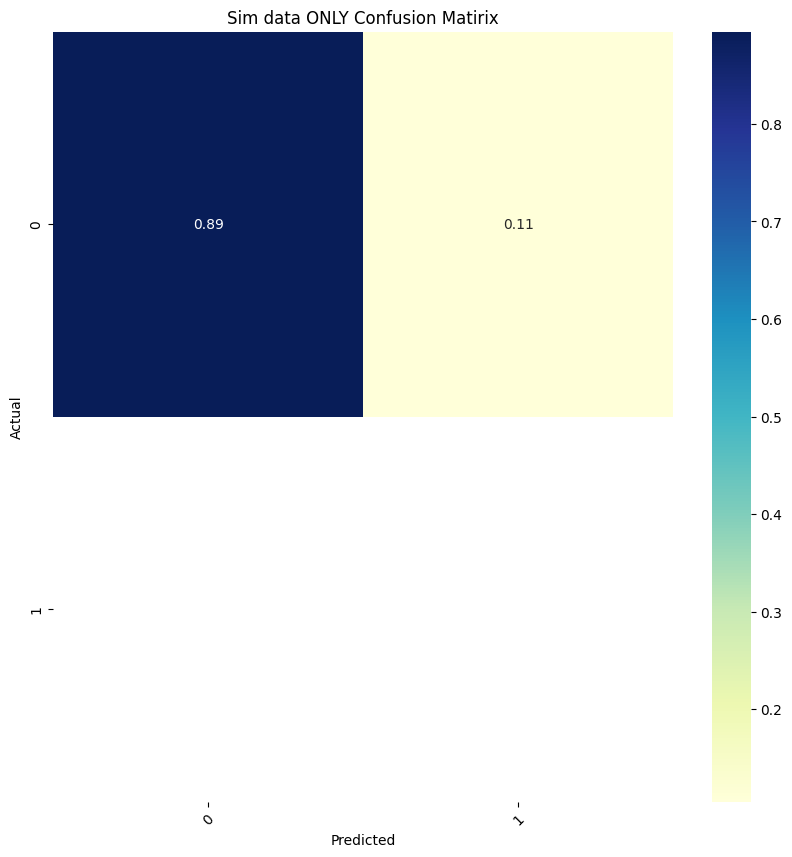


F1 Score: 0.4722222222222222
Precision: 1.0
Recall: 0.4473684210526316
Accuracy: 0.8947368421052632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Zach/mergedata/OldData/blueSIM_test1.csv')
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df1['type'] = 0 #SimData


df1['topics'] = df1['topics'].apply(lambda x: x.replace(" ", ""))
df1


# Encode labels in column 'species'.
df1['topics']= label_encoder.fit_transform(df1['topics'])
df1['msg']= label_encoder.fit_transform(df1['msg'])
df1['node']= label_encoder.fit_transform(df1['node'])
df1

#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df1.drop(predict, axis=1)
y = df1[predict]
print(X.head())
print(y.head())

predictions_df1 = (model.predict(X) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y, predictions_df1)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Sim data ONLY Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y, predictions_df1, average='binary')))
print('Precision: {}'.format(
    precision_score(y, predictions_df1, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y, predictions_df1, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y, predictions_df1, average='binary')))

In [ ]:
predictions_df1

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

    Run Time  msg  node  topics
0  290.89665   16     0       0
1  279.95296   21     4       5
2  279.94593   14     0       0
3  263.18176   32     5       2
4  261.81656   10     0       0
0    1
1    1
2    1
3    1
4    1
Name: type, dtype: int64
2/2 [==============================] - 0s 4ms/step
[[ 0  0]
 [30  8]] 



<ipython-input-39-9f9ab973bdb0>:29: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


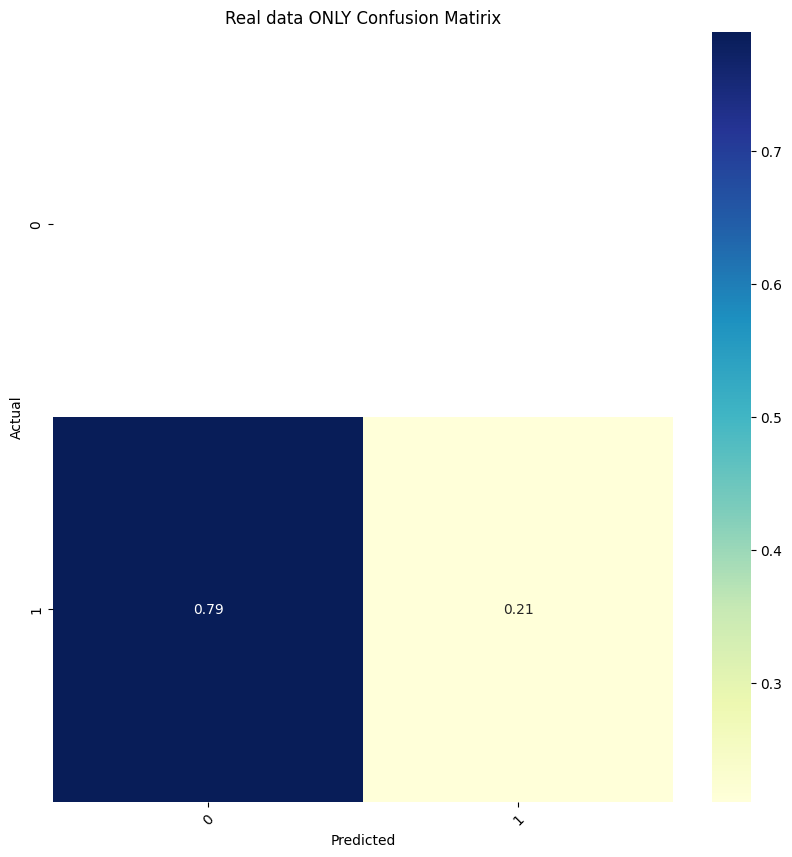


F1 Score: 0.17391304347826086
Precision: 1.0
Recall: 0.10526315789473684
Accuracy: 0.21052631578947367


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Zach/RealData/Blue Order 2 (Ready4_ML).csv')
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df1['type'] = 1 #RealData


df1['topics'] = df1['topics'].apply(lambda x: x.replace(" ", ""))
df1


# Encode labels in column 'species'.
df1['topics']= label_encoder.fit_transform(df1['topics'])
df1['msg']= label_encoder.fit_transform(df1['msg'])
df1['node']= label_encoder.fit_transform(df1['node'])
df1

#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df1.drop(predict, axis=1)
y = df1[predict]
print(X.head())
print(y.head())

predictions_df1 = (model.predict(X) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y, predictions_df1)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Real data ONLY Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y, predictions_df1, average='binary')))
print('Precision: {}'.format(
    precision_score(y, predictions_df1, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y, predictions_df1, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y, predictions_df1, average='binary')))

In [ ]:
predictions_df1

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)